In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
import time
from collections import deque
from datetime import datetime
from tqdm import tqdm
import serial 
import serial.tools.list_ports

In [ ]:
# ============================================
# ARDUINO SERIAL COMMUNICATION
# ============================================

def find_arduino_port():
    ports = serial.tools.list_ports.comports()
    
    for port in ports:
        # Look for Arduino
        if 'Arduino' in port.description or 'CH340' in port.description or 'USB' in port.description:
            return port.device
    
    # If not found, return None
    return None

def connect_arduino(port=None, baud_rate=9600):
    if port is None:
        port = find_arduino_port()
    
    if port is None:
        print("⚠️  Arduino not found! Running without hardware.")
        return None
    
    try:
        arduino = serial.Serial(port, baud_rate, timeout=1)
        time.sleep(2)  # Wait for Arduino to initialize
        
        # Read initial message
        if arduino.in_waiting:
            msg = arduino.readline().decode().strip()
            print(f"✅ Arduino connected on {port}")
            print(f"   Message: {msg}")
        
        return arduino
        
    except Exception as e:
        print(f"❌ Failed to connect to Arduino: {e}")
        return None

def send_to_arduino(arduino, status, threat_type=None, confidence=0):
    if arduino is None:
        return  # No Arduino connected
    
    try:
        if status == "SAFE":
            message = "SAFE\n"
        else:
            message = f"THREAT:{threat_type}:{int(confidence)}\n"
        
        arduino.write(message.encode())
        
        # Optional: Read acknowledgment
        if arduino.in_waiting:
            ack = arduino.readline().decode().strip()
            # print(f"Arduino: {ack}")  # Uncomment for debugging
            
    except Exception as e:
        print(f"⚠️  Arduino communication error: {e}")

In [65]:
# ============================================
# CONFIGURATION
# ============================================

MODEL_PATH = "xray_threat_detector_best.pt"
VIDEO_PATH = "XRay_Import.mp4"
OUTPUT_VIDEO_PATH = "xray_detection_output.mp4"
LOG_FILE = "detection_log.csv"

CONFIDENCE_THRESHOLD = 0.20
PROCESS_EVERY_N_FRAMES = 1
THREAT_MEMORY_FRAMES = 7

# Update these based on your model's classes
THREAT_CLASSES = ['Blade','Gun', 'Knife', 'Pin', 'Projectile', 'Screw', 'Spring']

In [66]:

# ============================================
# LOAD MODEL
# ============================================

def load_model(model_path):
    """Load trained YOLOv8 model."""
    print("📦 Loading model...")
    model = YOLO(model_path)
    print("✅ Model loaded!")
    return model

# ============================================
# THREAT DETECTION
# ============================================

def is_threat(class_name, confidence, threshold=0.50):
    """Check if detection is a threat."""
    return class_name in THREAT_CLASSES and confidence >= threshold

def create_scanner_overlay(frame, threat_status, threat_type, confidence, frame_num, fps, detections=None):
    """Add professional scanner overlay to frame."""
    height, width = frame.shape[:2]
    
    # Header bar
    cv2.rectangle(frame, (0, 0), (width, 60), (40, 40, 40), -1)
    cv2.putText(frame, "X-RAY BAGGAGE SCANNER - AI THREAT DETECTION",
               (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    cv2.putText(frame, timestamp, (width-250, 35),
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 200), 1)
    
    # Frame counter
    cv2.putText(frame, f"Frame: {frame_num}", (width-250, 55),
               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (200, 200, 200), 1)
    
    # Status box at bottom
    if threat_status:
        color = (0, 0, 255)  # Red
        text = f"⚠️ THREAT DETECTED: {threat_type} ({confidence:.0%})"
        
        # Flashing border
        if int(time.time() * 3) % 2 == 0:
            cv2.rectangle(frame, (5, 5), (width-5, height-5), color, 10)
    else:
        color = (0, 255, 0)  # Green
        text = "✓ STATUS: CLEAR"
    
    # Bottom status bar
    cv2.rectangle(frame, (0, height-60), (width, height), (40, 40, 40), -1)
    cv2.putText(frame, text, (10, height-20),
               cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    # FPS indicator
    cv2.putText(frame, f"FPS: {fps:.1f}", (10, height-45),
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    if detections:
        for det in detections:
            if 'box' in det:
                x1, y1, x2, y2 = det['box']
                color = (0, 0, 255) if det['is_threat'] else (0, 255, 0)
                
                # Draw box
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 3)
                
                # Label
                label = f"{det['type']} {det['confidence']:.0%}"
                cv2.putText(frame, label, (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    return frame


In [ ]:
# ============================================
# MAIN VIDEO PROCESSING
# ============================================

def process_video(model, video_path, output_path, show_preview=True):    
    print("\n" + "="*60)
    print("🎬 STARTING VIDEO PROCESSING")
    print("="*60)
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"❌ Cannot open video: {video_path}")
    
    arduino = connect_arduino()
    if arduino:
        print("✅ Arduino connected for threat alerts.")
    else:
        print("⚠️  Running without Arduino threat alerts.")
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"\n📊 Video Info:")
    print(f"   Resolution: {width}x{height}")
    print(f"   FPS: {fps}")
    print(f"   Total Frames: {total_frames}")
    print(f"   Duration: {total_frames/fps:.1f} seconds")
    
    # Video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Initialize CSV log
    with open(LOG_FILE, 'w') as f:
        f.write("Timestamp,Frame,Class,Confidence,Threat\n")
    
    # Tracking variables
    frame_count = 0
    threat_history = deque(maxlen=THREAT_MEMORY_FRAMES)
    detection_count = 0
    threat_count = 0
    start_time = time.time()
    
    print("\n🚀 Processing video...")
    print("   Press 'q' to stop early\n")
    
    # Progress bar
    pbar = tqdm(total=total_frames, desc="Processing", unit="frame")
    

    while True:
        ret, frame = cap.read()
    
        if not ret:
            break
    
        frame_count += 1
        pbar.update(1)
    
        # Calculate FPS
        elapsed = time.time() - start_time
        current_fps = frame_count / elapsed if elapsed > 0 else 0
    
        # === DETECTION SECTION (YOUR NEW CODE GOES HERE) ===
        threat_detected = False
        threat_type = "None"
        confidence = 0.0
        annotated_frame = frame.copy()
    
        if frame_count % PROCESS_EVERY_N_FRAMES == 0:
    
            # Run detection
            results = model(frame, conf=CONFIDENCE_THRESHOLD, verbose=False)

            if len(results) > 0:
                annotated_frame = results[0].plot()
        
            # Check for threats - COLLECT ALL
            detected_threats = []
        
            for result in results:
                boxes = result.boxes
            
                for box in boxes:
                    cls_id = int(box.cls[0])
                    conf = float(box.conf[0])
                    class_name = model.names[cls_id]
                
                    if is_threat(class_name, conf, CONFIDENCE_THRESHOLD):
                        detected_threats.append({
                            'type': class_name,
                            'confidence': conf
                        })
                    
                        # Log detection
                        with open(LOG_FILE, 'a') as f:
                            f.write(f"{datetime.now()},{frame_count},{class_name},{conf:.3f},TRUE\n")
        
            # Update threat status
            if detected_threats:
                threat_detected = True
                best_threat = max(detected_threats, key=lambda x: x['confidence'])
                threat_type = best_threat['type']
                confidence = best_threat['confidence']
            
                # Show ALL threats
                threat_type = ", ".join([t['type'] for t in detected_threats])
                confidence = max([t['confidence'] for t in detected_threats])
                detection_count += 1
            else:
                threat_detected = False
                threat_type = "None"
                confidence = 0.0
    
        frame = annotated_frame
    
        # Update threat history
        threat_history.append(threat_detected)
    
        # Trigger alarm
        alarm_triggered = threat_detected  # Direct response
    
        if alarm_triggered and threat_detected:
            threat_count += 1
            send_to_arduino(arduino, "THREAT", threat_type, confidence * 100)
        else:
            send_to_arduino(arduino, "SAFE")
    
        # Add overlay
        frame = create_scanner_overlay(
            frame, 
            alarm_triggered, 
            threat_type, 
            confidence,
            frame_count,
            current_fps
        )
    
        # Write frame to output video
        out.write(frame)
    
        # Show preview
        if show_preview:
            cv2.imshow('X-Ray Threat Detection', frame)
        
            if cv2.waitKey(1) & 0xFF == ord('q'):
                print("\n⚠️ Stopped by user")
                break
# END OF WHILE LOOP
    
        
        # Trigger alarm if threats in recent frames
        alarm_triggered = threat_detected
        
        if alarm_triggered and threat_detected:
            threat_count += 1
        
        # Add overlay
        frame = create_scanner_overlay(
            frame, 
            alarm_triggered, 
            threat_type, 
            confidence,
            frame_count,
            current_fps
        )
        
        # Write frame
        out.write(frame)
        
        # Show preview
        if show_preview:
            cv2.imshow('X-Ray Threat Detection', frame)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                print("\n⚠️ Stopped by user")
                break
    
    # Cleanup
    pbar.close()
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    if arduino:
        send_to_arduino(arduino, "SAFE")
        arduino.close()
        print("✅ Arduino connection terminated.")
    
    # Summary
    print("\n" + "="*60)
    print("✅ VIDEO PROCESSING COMPLETE!")
    print("="*60)
    print(f"\n📊 Statistics:")
    print(f"   Total Frames Processed: {frame_count}")
    print(f"   Frames with Detections: {detection_count}")
    print(f"   Threat Alerts Triggered: {threat_count}")
    print(f"   Processing Time: {elapsed:.1f} seconds")
    print(f"   Average FPS: {current_fps:.1f}")
    print(f"\n💾 Outputs:")
    print(f"   Annotated Video: {output_path}")
    print(f"   Detection Log: {LOG_FILE}")


In [68]:

# ============================================
# TESTING: PROCESS SINGLE FRAME
# ============================================

def test_single_frame(model, video_path, frame_number=100):
    """Test detection on a single frame."""
    print("\n🧪 Testing single frame detection...")
    
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    ret, frame = cap.read()
    if not ret:
        print("❌ Could not read frame")
        return
    
    # Run detection
    results = model(frame, conf=CONFIDENCE_THRESHOLD, verbose=False)
    
    # Annotate
    annotated = results[0].plot()
    
    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title(f'Detection Test - Frame {frame_number}')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('test_detection.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Test frame saved as 'test_detection.png'")
    
    cap.release()

In [69]:

# ============================================
# MAIN PIPELINE
# ============================================

def run_phase2_pipeline(
    model_path=MODEL_PATH,
    video_path=VIDEO_PATH,
    output_path=OUTPUT_VIDEO_PATH,
    test_first=True,
    show_preview=True
):
    """
    Complete Phase 2 pipeline.
    
    Args:
        model_path: Path to trained model
        video_path: Input video
        output_path: Output video path
        test_first: Test on single frame first
        show_preview: Show live processing window
    """
    
    print("""
    ╔══════════════════════════════════════════════════════════╗
    ║                                                          ║
    ║         X-RAY THREAT DETECTION - PHASE 2                 ║
    ║              Real-Time Video Processing                  ║
    ║                                                          ║
    ╚══════════════════════════════════════════════════════════╝
    """)
    
    # Load model
    model = load_model(model_path)
    
    # Optional: Test on single frame first
    if test_first:
        test_single_frame(model, video_path, frame_number=50)
        
        proceed = input("\n▶️  Continue with full video processing? (y/n): ")
        if proceed.lower() != 'y':
            print("⏸️  Processing cancelled")
            return
    
    # Process full video
    process_video(model, video_path, output_path, show_preview=show_preview)
    
    print("\n🎉 Phase 2 Complete!")
    print("\n📁 Check these files:")
    print(f"   - {output_path} (annotated video)")
    print(f"   - {LOG_FILE} (detection log)")
    print("\n🚀 Ready for Phase 3: Arduino Integration!")


    ╔══════════════════════════════════════════════════════════╗
    ║                                                          ║
    ║         X-RAY THREAT DETECTION - PHASE 2                 ║
    ║              Real-Time Video Processing                  ║
    ║                                                          ║
    ╚══════════════════════════════════════════════════════════╝
    
📦 Loading model...
✅ Model loaded!

🧪 Testing single frame detection...


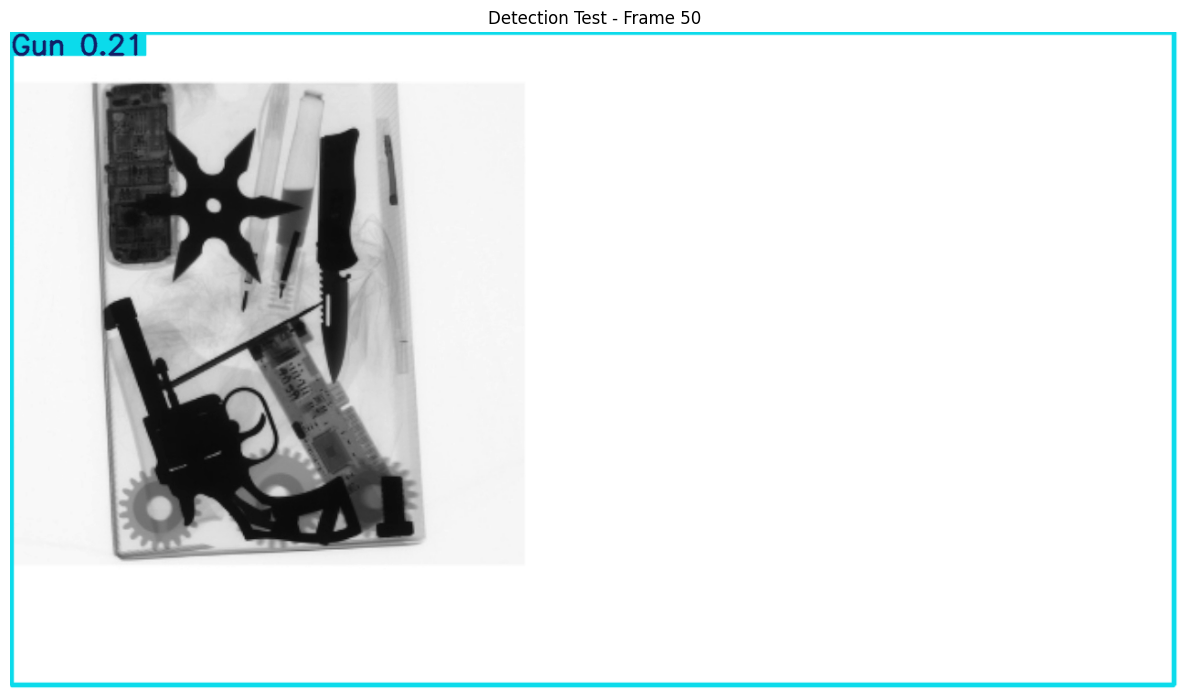

✅ Test frame saved as 'test_detection.png'

🎬 STARTING VIDEO PROCESSING

📊 Video Info:
   Resolution: 1280x720
   FPS: 29
   Total Frames: 900
   Duration: 31.0 seconds

🚀 Processing video...
   Press 'q' to stop early



Processing: 100%|██████████| 900/900 [01:37<00:00,  9.23frame/s]


✅ VIDEO PROCESSING COMPLETE!

📊 Statistics:
   Total Frames Processed: 900
   Frames with Detections: 800
   Threat Alerts Triggered: 1600
   Processing Time: 97.4 seconds
   Average FPS: 9.2

💾 Outputs:
   Annotated Video: xray_detection_output.mp4
   Detection Log: detection_log.csv

🎉 Phase 2 Complete!

📁 Check these files:
   - xray_detection_output.mp4 (annotated video)
   - detection_log.csv (detection log)

🚀 Ready for Phase 3: Arduino Integration!


In [70]:
# ============================================
# USAGE
# ============================================

if __name__ == "__main__":
    
    # Run complete Phase 2 pipeline
    run_phase2_pipeline(
        model_path="xray_threat_detector_best.pt",
        video_path="XRay_Import.mp4",
        output_path="xray_detection_output.mp4",
        test_first=True,      # Test on one frame first
        show_preview=True     # Show live window
    )